In [1]:
import numpy as np
import sys
sys.path.append('../..')
from utils.workflow import WorkflowModel
from utils.data import RK4DataGenerator, stack_real_values, mono_beta
import utils.plotting as plotting
from utils.eval import eval_predictions

2025-12-30 21:51:39.683613: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-30 21:51:39.718512: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-30 21:51:40.849472: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Set the default float type to float64


E0000 00:00:1767142302.305230  589788 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1767142302.315515  589788 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
t_0, t_f, N = 0, 52, 100 
nop_data = t_f + 1
S0, I0, R0 = 99, 1, 0
noise_std = 2
test_t = np.linspace(t_0, t_f, nop_data)
rkdata = RK4DataGenerator(mono_beta, 
    t_0=t_0, 
    t_f=t_f, 
    N=N, 
    S0=S0, I0=I0, R0=R0
)
sir_real = rkdata.generate(test_t)
sir_data = rkdata.generate(test_t, noise_std)

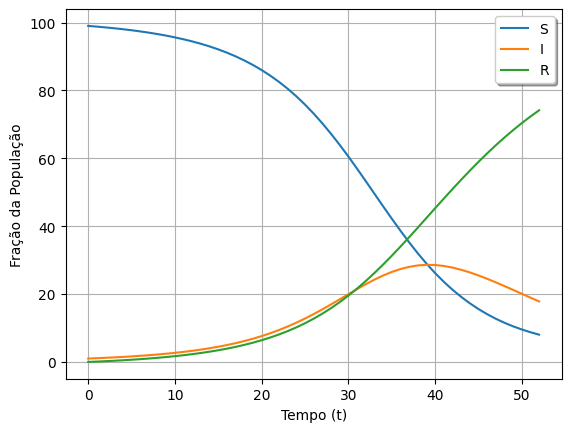

In [3]:
plotting.plot_rk_curves(test_t, sir_real)

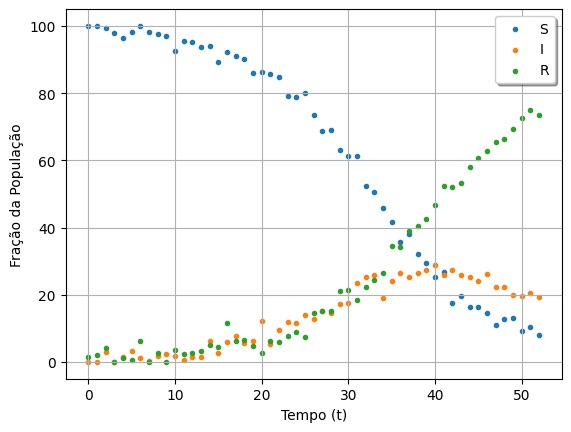

In [4]:
plotting.plot_rk_data(test_t, sir_data)

In [5]:
model = WorkflowModel(t_0, t_f, sir_data[:,1], test_t,
    N=N,
    hidden_layer_size=30,
    n_hidden_layers=3,
    scaling="min/max",
    early_stopping=True,
    beta_hard_constraints=False,
    adaptative_wdata=False)
model.S0, model.I0

Compiling model...
'compile' took 0.004696 s



(np.float64(3.4741758396925904), np.float64(0.0))

In [6]:
model.train()

(<deepxde.model.LossHistory at 0x7ff542ce6790>,
 <deepxde.model.TrainState at 0x7ff51fe854d0>)

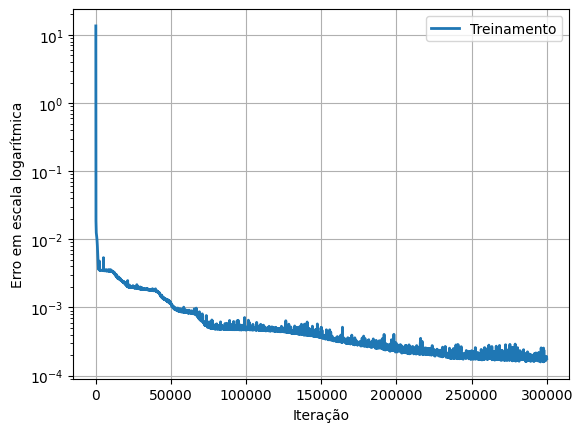

In [7]:
plotting.plot_losshistory(model.losshistory)

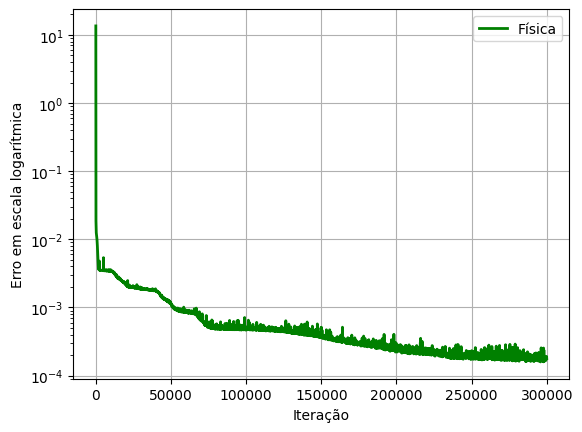

In [8]:
plotting.plot_phys_losshistory(model.losshistory)

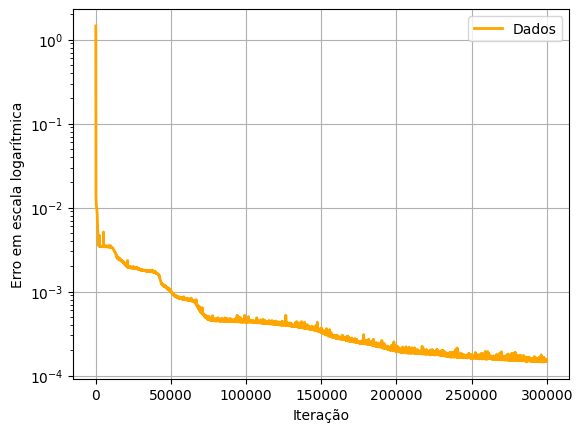

In [9]:
plotting.plot_data_losshistory(model.losshistory)

In [10]:
predictions = model.predict(test_t)

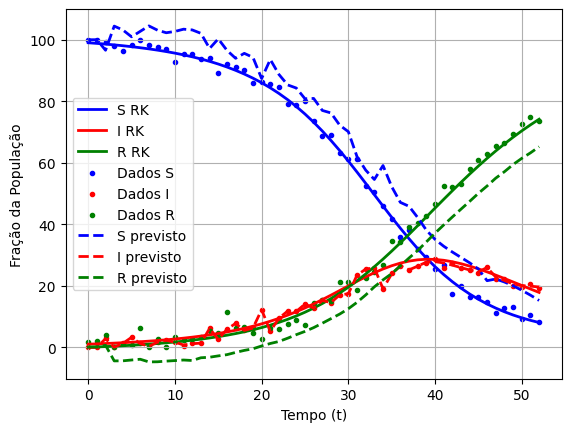

In [11]:
plotting.plot_results(sir_real, sir_data, predictions, test_t, N=N)

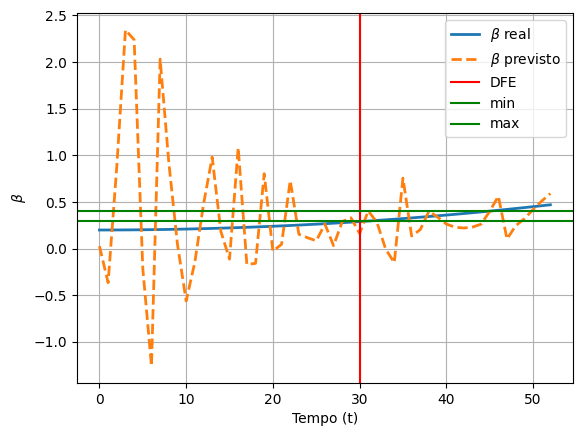

In [12]:
real_beta = mono_beta(test_t)
plotting.plot_beta_comparison(real_beta, predictions[:,2], test_t, 
    vlines=[(30, "DFE", "red")], 
    hlines=[(0.3, "min", "green"), (0.4, "max", "green")])

In [13]:
if model.data_weight_hist:
    plotting.plot_wdata(model.data_weight_hist)

In [23]:
real_values = stack_real_values(sir_real, real_beta)
#display(eval_predictions(real_values, predictions))
from IPython.display import Markdown
display(Markdown(eval_predictions(real_values, predictions).to_latex()))

\begin{tabular}{llrrr}
\toprule
 & compartiment & MSE & L2 & L-infinity \\
\midrule
0 & S & 58.037117 & 0.108093 & 13.190081 \\
1 & I & 3.464128 & 0.106914 & 6.433108 \\
2 & beta & 0.376127 & 2.028080 & 2.143871 \\
\bottomrule
\end{tabular}


In [19]:
model.formated_total_training_time

'00:04:10'